# MONGY: Training `PatchTSMixer` on Financial Candlestick Data
## Direct forecasting example

This notebooke demonstrates the usage of a `PatchTSMixer` model for a multivariate time series forecasting task. This notebook has a dependecy on HuggingFace [transformers](https://github.com/huggingface/transformers) repo. For details related to model architecture, refer to the [TSMixer paper](https://arxiv.org/abs/2306.09364).

In [1]:
# Standard
import os
import random

# Third Party
from transformers import (
    EarlyStoppingCallback,
    PatchTSMixerConfig,
    PatchTSMixerForPrediction,
    Trainer,
    TrainingArguments,
)
import numpy as np
import pandas as pd
import torch

# First Party
from tsfm_public.toolkit.dataset import ForecastDFDataset, BaseDFDataset
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor

In [2]:
# Set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [345]:
# We want to setup our context, horizon, and patch size based on our task. We want to use
# 4 hours of lookback to start, in order to predict the next 5 minutes of candles. Regarding
# patch length, we know that we will want a larger patch size, so we will start with 64 as
# a base case assumption
context_length = 60 * 4  # This will give us 4 hours of lookback (6 candles per min * 60 min per hour)
forecast_horizon = 3 # This will give us 3 minutes of predictions
forecast_single = 1

In [430]:
# Load the Dataset from the CSV file
DATA_DIR = "/home/ubuntu/verb-workspace/data"

TEST_DATASET = f"{DATA_DIR}/1min-candles-test-w-CANDLES.csv"

timestamp_col = 't'

test_data = pd.read_csv(
    TEST_DATASET,
    parse_dates=[timestamp_col]
)


In [431]:
test_data.head()

,ticker,date_string,t,targ_o,targ_h,targ_l,targ_c,targ_v,targ_vwap,targ_red,targ_green,cont_market_open,cont_market_extended
0,AAPL,2023-01-23,2023-01-23 05:30:00-05:00,137.32,137.32,137.32,137.32,270.0,137.3304,0,0,0,1
1,AAPL,2023-01-23,2023-01-23 05:31:00-05:00,137.32,137.35,137.25,137.25,2893.0,137.3064,1,0,0,1
2,AAPL,2023-01-23,2023-01-23 05:32:00-05:00,137.25,137.25,137.22,137.22,1208.0,137.2449,1,0,0,1
3,AAPL,2023-01-23,2023-01-23 05:33:00-05:00,137.22,137.25,137.22,137.25,3444.0,137.2497,0,1,0,1
4,AAPL,2023-01-23,2023-01-23 05:34:00-05:00,137.25,137.25,137.25,137.25,0.0,0.0000,0,0,0,1


In [432]:
# Check for NaN values
assert sum(test_data.isna().sum().to_list()) == 0
assert sum(vwap_targ_dataset.isna().sum().to_list()) == 0

In [433]:


id_columns = ['ticker', 'date_string']
forecast_columns = ['targ_o', 'targ_c', 'targ_h', 'targ_l', 'targ_v', 'targ_vwap', 'targ_red', 'targ_green']
control_columns = ['cont_market_open', 'cont_market_extended']

test_tsp = TimeSeriesPreprocessor(
    timestamp_column=timestamp_col,
    id_columns=id_columns,
    target_columns=forecast_columns,
    control_columns=control_columns,
    scaling=True,
)
test_tsp.train(test_data)
print("Done Test Set")

Done Test Set


In [434]:
dataset = ForecastDFDataset(
    targ_vwap_tsp.preprocess(vwap_targ_dataset),
    id_columns=id_columns,
    timestamp_column=timestamp_col,
    target_columns=forecast_columns_alt,
    control_columns=control_columns,
    context_length=context_length,
    prediction_length=forecast_horizon,
)

## Training `PatchTSMixer` From Scratch

Adjust the following model parameters according to need.
- `d_model` (`int`, *optional*, defaults to 8):
    Hidden dimension of the model. Recommended to set it as a multiple of patch_length (i.e. 2-8X of
    patch_len). Larger value indicates more complex model.
- `expansion_factor` (`int`, *optional*, defaults to 2):
    Expansion factor to use inside MLP. Recommended range is 2-5. Larger value indicates more complex model.
- `num_layers` (`int`, *optional*, defaults to 3):
    Number of layers to use. Recommended range is 3-15. Larger value indicates more complex model.
- `mode`: (`str`, either to 'common_channel' or `mix_channel`)

In [502]:
# Indices for accessing the OHLC values in the tensors
I_OPEN = 0
I_CLOSE = 1
I_HIGH = 2
I_LOW = 3
I_VOLUME = 4
I_RED = 5
I_GREEN = 6

from typing import Optional

from transformers.models.patchtsmixer.modeling_patchtsmixer import PatchTSMixerForPredictionOutput

class MongyModel(PatchTSMixerForPrediction):

    def forward(
        self,
        past_values: torch.Tensor,
        observed_mask: Optional[torch.Tensor] = None,
        future_values: Optional[torch.Tensor] = None,
        output_hidden_states: Optional[bool] = False,
        return_loss: bool = True,
        return_dict: Optional[bool] = None,
    ) -> PatchTSMixerForPredictionOutput:
        r"""
        observed_mask (`torch.FloatTensor` of shape `(batch_size, sequence_length, num_input_channels)`, *optional*):
            Boolean mask to indicate which `past_values` were observed and which were missing. Mask values selected
            in `[0, 1]`:
                - 1 for values that are **observed**,
                - 0 for values that are **missing** (i.e. NaNs that were replaced by zeros).
        future_values (`torch.FloatTensor` of shape `(batch_size, target_len, num_input_channels)` for forecasting,:
            `(batch_size, num_targets)` for regression, or `(batch_size,)` for classification, *optional*): Target
            values of the time series, that serve as labels for the model. The `future_values` is what the
            Transformer needs during training to learn to output, given the `past_values`. Note that, this is NOT
            required for a pretraining task.

            For a forecasting task, the shape is be `(batch_size, target_len, num_input_channels)`. Even if we want
            to forecast only specific channels by setting the indices in `prediction_channel_indices` parameter,
            pass the target data with all channels, as channel Filtering for both prediction and target will be
            manually applied before the loss computation.
        return_loss (`bool`,  *optional*):
            Whether to return the loss in the `forward` call.

        Returns:

        """
        if self.loss == "mse":
            # loss = torch.nn.MSELoss(reduction="mean")
            loass = custom_loss
        elif self.loss == "nll":
            loss = nll
        else:
            raise ValueError("Invalid loss function: Allowed values: mse and nll")

        return_dict = return_dict if return_dict is not None else self.use_return_dict

        # past_values: tensor [batch_size x context_length x num_input_channels]
        model_output = self.model(
            past_values,
            observed_mask=observed_mask,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )  # model_output: [batch_size x nvars x num_patch x d_model]

        
        if isinstance(model_output, tuple):
            model_output = PatchTSMixerModelOutput(*model_output)

        # tensor [batch_size x prediction_length x num_input_channels]
        y_hat = self.head(model_output.last_hidden_state)

        # # Snap the candles to the correct opening positions, before computing the loss
        # # This is the "training wheels" for the head. By helping the model with the portion
        # # of it's task that we can help with, we severly limit the task that is posed to the
        # # model
        
        last_context_close = past_values[..., -1, I_CLOSE]
        first_candle_open = y_hat[..., 0, I_OPEN]
        first_candle_delta = last_context_close - first_candle_open
        first_candle_delta = first_candle_delta.unsqueeze(-1).unsqueeze(-1)
        y_hat[..., 0:4] = y_hat[..., 0:4] + first_candle_delta


        first_candle_close = y_hat[..., 0, I_CLOSE]
        second_candle_open = y_hat[..., 1, I_OPEN]
        second_candle_delta = first_candle_close - second_candle_open
        y_hat[..., -2:, 0:4] = y_hat[..., -2:, 0:4] + second_candle_delta

        second_candle_close = y_hat[..., 1, I_CLOSE]
        third_candle_open = y_hat[..., 2, I_OPEN]
        third_candle_delta = second_candle_close - third_candle_open
        y_hat[..., -1, 0:4] = y_hat[..., -1, 0:4] + third_candle_delta


        loss_val = None
        if self.prediction_channel_indices is not None:
            if self.distribution_output:
                distribution = self.distribution_output.distribution(
                    y_hat,
                    loc=model_output.loc[..., self.prediction_channel_indices],
                    scale=model_output.scale[..., self.prediction_channel_indices],
                )
                if future_values is not None and return_loss is True:
                    loss_val = loss(
                        distribution,
                        future_values[..., self.prediction_channel_indices],
                    )
                    # take average of the loss
                    loss_val = weighted_average(loss_val)
            else:
                y_hat = (
                    y_hat * model_output.scale[..., self.prediction_channel_indices]
                    + model_output.loc[..., self.prediction_channel_indices]
                )
                if future_values is not None and return_loss is True:
                    loss_val = loss(y_hat, future_values[..., self.prediction_channel_indices])
        else:
            if self.distribution_output:
                distribution = self.distribution_output.distribution(
                    y_hat, loc=model_output.loc, scale=model_output.scale
                )
                if future_values is not None and return_loss is True:
                    loss_val = loss(distribution, future_values)
                    loss_val = weighted_average(loss_val)
            else:
                y_hat = y_hat * model_output.scale + model_output.loc
                if future_values is not None and return_loss is True:
                    loss_val = loss(y_hat, future_values)

        if self.prediction_channel_indices is not None:
            loc = model_output.loc[..., self.prediction_channel_indices]
            scale = model_output.scale[..., self.prediction_channel_indices]
        else:
            loc = model_output.loc
            scale = model_output.scale

        if not return_dict:
            return tuple(
                v
                for v in [
                    loss_val,
                    y_hat,
                    model_output.last_hidden_state,
                    model_output.hidden_states,
                    loc,
                    scale,
                ]
            )

        return PatchTSMixerForPredictionOutput(
            loss=loss_val,
            prediction_outputs=y_hat,  # tensor [batch_size x prediction_length x num_input_channels]
            last_hidden_state=model_output.last_hidden_state,  # x: [batch_size x nvars x num_patch x d_model]
            hidden_states=model_output.hidden_states,
            loc=loc,
            scale=scale,
        )

In [546]:
run_num_1 = "morning_1"
model_dir_1 = f"./checkpoints/run_{run_num_1}/output/checkpoint-9500"
model_1 = MongyModel.from_pretrained(model_dir_1)
model_1.eval()

run_num_2 = "day_1"
model_dir_2 = f"./checkpoints/run_{run_num_2}/output/checkpoint-2000"
model_2 = MongyModel.from_pretrained(model_dir_2)
model_2.eval()

run_num_3 = "vwap_targ_3"
model_dir_3 = f"./checkpoints/run_{run_num_3}/output/checkpoint-10000"
model_3 = MongyModel.from_pretrained(model_dir_3)
model_3.eval()

model_dict = {
    "Morning Model (Step 9500)": (model_1, dataset),
    "Day Model (Step 2000)": (model_2, dataset),
    "VWAP Model  (Step 10000) | weight_decay = 1e-5)": (model_3, dataset)
}

In [547]:
from torchsummary import summary

# # Provide the input size of your model
# summary(model, (240, 512))

## Model Test Bench

In [548]:
import time
from typing import Tuple

def run_inference(context: torch.Tensor, futures: torch.Tensor, _model: MongyModel, log_time: bool = False) -> torch.Tensor:
    model.eval()
    
    with torch.no_grad():
        start = time.perf_counter()
        _forecasts = _model(context.unsqueeze(0), future_values=futures.unsqueeze(0), return_loss=False).prediction_outputs
        end = time.perf_counter()

        if log_time:
            print(f"Ran Inference in {end - start} seconds")
        return _forecasts.squeeze(0)

In [549]:
def post_process(_context: torch.Tensor, _futures: torch.Tensor, _forecasts: torch.Tensor, ticker: str, date_str: str) -> Tuple[torch.tensor]:
    _context_df = pd.DataFrame({
        'ticker': ticker,
        'date_string': date_str,
        'targ_o': _context[:,0].numpy(),
        'targ_c': _context[:,1].numpy(),
        'targ_h': _context[:,2].numpy(),
        'targ_l': _context[:,3].numpy(),
        'targ_v': _context[:,4].numpy(),
        'targ_red': _context[:,5].numpy(),
        'targ_green': _context[:,6].numpy(),
    })
    _futures_df = pd.DataFrame({
        'ticker': ticker,
        'date_string': date_str,
        'targ_o': _futures[:,0].numpy(),
        'targ_c': _futures[:,1].numpy(),
        'targ_h': _futures[:,2].numpy(),
        'targ_l': _futures[:,3].numpy(),
        'targ_v': _futures[:,4].numpy(),
        'targ_red': _futures[:,5].numpy(),
        'targ_green': _futures[:,6].numpy(),
    })
    _forecasts_df = pd.DataFrame({
        'ticker': ticker,
        'date_string': date_str,
        'targ_o': _forecasts[:,0].numpy(),
        'targ_c': _forecasts[:,1].numpy(),
        'targ_h': _forecasts[:,2].numpy(),
        'targ_l': _forecasts[:,3].numpy(),
        'targ_v': _forecasts[:,4].numpy(),
        'targ_red': _forecasts[:,5].numpy(),
        'targ_green': _forecasts[:,6].numpy(),
    })

    inverse_scaled_context = scaled_test_tsp.inverse_scale_targets(_context_df)
    inverse_scaled_futures = scaled_test_tsp.inverse_scale_targets(_futures_df)
    inverse_scaled_forecasts = scaled_test_tsp.inverse_scale_targets(_forecasts_df)
    
    # Convert context data to OHLC candle data
    context_ohlc = pd.DataFrame({
        'Open': inverse_scaled_context['targ_o'],
        'Close': inverse_scaled_context['targ_c'],
        'High': inverse_scaled_context['targ_h'],
        'Low': inverse_scaled_context['targ_l'],
    })
    
    # Convert futures to OHLC candle data
    futures_ohlc = pd.DataFrame({
        'Open': inverse_scaled_futures['targ_o'],
        'Close': inverse_scaled_futures['targ_c'],
        'High': inverse_scaled_futures['targ_h'],
        'Low': inverse_scaled_futures['targ_l'],
    })

    # Convert the forecasts to OHLC data
    forecasts_ohlc = pd.DataFrame({
        'Open': inverse_scaled_forecasts['targ_o'],
        'Close': inverse_scaled_forecasts['targ_c'],
        'High': inverse_scaled_forecasts['targ_h'],
        'Low': inverse_scaled_forecasts['targ_l'],
    })
    
    
    reals_ohlc = pd.concat([context_ohlc, futures_ohlc])
    return reals_ohlc, forecasts_ohlc

In [550]:
def plot_candles(reals: pd.DataFrame, forecasts_dict: dict, context_start_ts: pd.Timestamp) -> None:
    # Create custom styles for context, future, and forecast candles
    reals_style = mpf.make_mpf_style(base_mpf_style='yahoo', rc={'figure.facecolor': 'w', 'axes.facecolor': 'w'})
    forecast_style = {
        'marketcolors': {
            'candle': {'up': 'white', 'down': 'black'},
            'edge': {'up': 'black', 'down': 'black'},
            'wick': {'up': 'black', 'down': 'black'},
            'ohlc': {'up': 'white', 'down': 'black'},
            'volume': {'up': 'white', 'down': 'black'},
            'vcedge': {'up': 'white', 'down': 'black'},
            'vcdopcod': False,
            'alpha': 0.9
        }, 
        'mavcolors': None,
        'y_on_right': True,
    }
    
    # Create a figure and axes
    num_models = len(forecasts_dict)
    fig, axes = plt.subplots(num_models, 1, figsize=(12, 4 * num_models), sharex=True)
    
    # Create a time series with a duration of 4 hours and 20 minutes at a 1-minute frequency
    end_time = context_start_ts + pd.Timedelta(hours=4, minutes=2)  # Should get us the 4 hrs, 3min of time stamps
    reals_index = pd.date_range(start=context_start_ts, end=end_time, freq='1min')
    
    # Set the created time series as the index of reals_ohlc
    reals.index = reals_index
    
    # Trim reals to only contain 1 hour of data
    reals = reals.iloc[-60:]
    
    for i, (model_name, forecasts) in enumerate(forecasts_dict.items()):
        ax = axes[i] if num_models > 1 else axes
        
        # Create a new DataFrame to store the padded forecast candles
        padded_forecasts = pd.DataFrame(0.0, index=reals_index, columns=forecasts.columns)
        padded_forecasts.iloc[-3:] = forecasts
        
        # Trim padded_forecasts to only contain 1 hour of data
        padded_forecasts = padded_forecasts.iloc[-60:]
        
        # Plot the real candles on the current axis
        mpf.plot(reals, type='candle', ax=ax, style=reals_style)
        
        # Plot the padded forecast candles on top of the real candles
        mpf.plot(padded_forecasts, type='candle', ax=ax, style=forecast_style)
        
        # Set the same y-limits for both axes
        y_min = min(reals['Low'].min(), forecasts['Low'].min())
        y_max = max(reals['High'].max(), forecasts['High'].max())
        ax.set_ylim(y_min, y_max)
        
        # Set plot title and labels
        ax.set_title(f'{model_name} - Aggregated 1-Minute Candles')
        ax.set_xlabel('Candle Index')
        ax.set_ylabel('Price')
    
    # Show the plot
    plt.tight_layout()
    plt.show()

In [551]:
from typing import Tuple
# Indices for accessing the OHLC values in the tensors
I_OPEN = 0
I_CLOSE = 1
I_HIGH = 2
I_LOW = 3
I_RED = 5
I_GREEN = 6


def _weighted_average(tensor):
    # Get the shape of the tensor
    shape = tensor.shape
    
    # Create a tensor of weights based on the last dimension
    weights = torch.arange(shape[-1], 0, -1, dtype=tensor.dtype, device=tensor.device)
    
    # Multiply the tensor by the weights along the last dimension
    weighted_tensor = tensor * weights
    
    # Sum the weighted tensor along the last dimension
    sum_weighted_tensor = torch.sum(weighted_tensor, dim=-1)
    
    # Sum the weights
    sum_weights = torch.sum(weights)
    
    # Compute the weighted average
    weighted_avg = sum_weighted_tensor / sum_weights
    
    return weighted_avg
    

def theta_body(y_pred: torch.Tensor, y_obs: torch.Tensor) -> torch.Tensor:
    # Create the series of closes
    real_candle_closes = y_obs[..., I_CLOSE]
    forecasted_candle_closes = y_pred[..., I_CLOSE]

    # Get the series of opens
    real_candle_opens = y_obs[..., I_OPEN]
    forecasted_candle_opens = y_pred[..., I_OPEN]

    # Get the series of candle bodies
    real_bodies = real_candle_closes - real_candle_opens
    forecasted_bodies = forecasted_candle_closes - forecasted_candle_opens

    # Get the error of each body
    error = real_bodies - forecasted_bodies

    sq_error = _weighted_average(torch.square(error))
    abs_error = _weighted_average(torch.abs(error))
    return sq_error, abs_error

def theta_single_pnl(x: torch.Tensor, y_pred: torch.Tensor, y_obs: torch.Tensor) -> torch.Tensor:
    # Get the close of the last real candle
    last_candle_close = x[..., -1, I_CLOSE]
    real_last_candle_close = y_obs[..., -1, I_CLOSE]
    real_forecasted_candle_close = y_pred[..., -1, I_CLOSE]

    # Compute if the position should be long or short, based on the real values
    is_long = real_last_candle_close > last_candle_close

    # Compute P/L of long position
    pnl_long_real = real_last_candle_close - last_candle_close
    pnl_long_forecasted = real_forecasted_candle_close - last_candle_close
    # Compute P/L of short position
    pnl_short_real = last_candle_close - real_last_candle_close
    pnl_short_forecasted = last_candle_close - real_forecasted_candle_close

    # Compute the P/L of the real candles vs forecasted candles
    pnl_real = torch.where(is_long, pnl_long_real, pnl_long_forecasted)
    pnl_forecasted = torch.where(is_long, pnl_short_real, pnl_short_forecasted)

    error = pnl_real - pnl_forecasted

    sq_error = torch.square(error)
    abs_error = torch.abs(error)
    return sq_error, abs_error

def base_error(y_pred: torch.Tensor, y_obs: torch.Tensor) -> Tuple[torch.Tensor]:
    # Place a mask over y_obs, to ensure it is the same size as y_pred
    y_obs = y_obs[..., :y_pred.shape[-1]]
    
    error = y_obs - y_pred

    raw_sq_error = torch.mean(torch.square(error), dim=-1)
    raw_ae_error = torch.mean((torch.abs(error)), dim=-1)

    sq_error = _weighted_average(raw_sq_error)
    ae_error = _weighted_average(raw_ae_error)
    
    return sq_error, ae_error


def custom_loss(x: torch.Tensor, y_pred: torch.Tensor, y_obs: torch.Tensor) -> torch.Tensor:
    # Compute PNL rediual for each candle
    mse, mae = base_error(y_pred, y_obs)
    pnl_se, pnl_ae = theta_single_pnl(x, y_pred, y_obs)
    body_se, body_ae = theta_body(y_pred, y_obs)

    custom_mse = torch.mean(mse + pnl_se + body_se)
    custom_mae = torch.mean(mae + pnl_ae + body_ae)

    return (custom_mse + custom_mae) / 2

In [552]:
def infer_and_plot(index: int, models: dict, plot: bool = True) -> dict:
    # Get the metadata for the example
    default_example = scaled_test_dataset[index]
    
    ticker, date_str = default_example['id']
    ts = pd.Timestamp(default_example['timestamp']).tz_localize("UTC").tz_convert("America/New_York")
    context_start = ts - pd.Timedelta(hours=3, minutes=59)

    print(f"{ticker} {date_str}: {ts.strftime('%I:%M %p')}")
    print("================================")

    forecasts_dict = {}
    for model_name, (model, dataset) in models.items():
        example = dataset[index]
        
        # Get an example for inference
        _context = example['past_values']
        _futures = example['future_values']
        _forecasts = run_inference(_context, _futures, model)

        base_loss = base_error(_forecasts, _futures)
        body_loss = theta_body( _forecasts, _futures)
        pnl_loss = theta_single_pnl(_context, _forecasts, _futures)
        
        # Print the evaluation metrics for each model
        print(f"{model_name} - Base Loss Component: SQ {base_loss[0]} -- ABS {base_loss[1]}")
        print(f"{model_name} - Body Loss Component: SQ {body_loss[0]} -- ABS {body_loss[1]}")
        print(f"{model_name} - P/L Loss Component: SQ {pnl_loss[0]} -- ABS {pnl_loss[1]}")
        forecasts_dict[model_name] = _forecasts

    if plot:
        forecasts_ohlc_dict = {}
        for model_name, _forecasts in forecasts_dict.items():
            reals_ohlc, forecast_ohlc = post_process(_context, _futures, _forecasts, ticker, date_str)
            forecasts_ohlc_dict[model_name] = forecast_ohlc
        
        plot_candles(reals_ohlc, forecasts_ohlc_dict, context_start)
    return forecasts_dict

AAPL 2023-01-23: 09:31 AM
Morning Model (Step 9500) - Base Loss Component: SQ 0.7819470763206482 -- ABS 0.6683333516120911
Morning Model (Step 9500) - Body Loss Component: SQ 0.07649651914834976 -- ABS 0.2516123652458191
Morning Model (Step 9500) - P/L Loss Component: SQ 0.7417329549789429 -- ABS 0.8612391948699951
Day Model (Step 2000) - Base Loss Component: SQ 1.9967759847640991 -- ABS 0.8985228538513184
Day Model (Step 2000) - Body Loss Component: SQ 0.08746076375246048 -- ABS 0.28183451294898987
Day Model (Step 2000) - P/L Loss Component: SQ 0.7417329549789429 -- ABS 0.8612391948699951
VWAP Model  (Step 10000) | weight_decay = 1e-5) - Base Loss Component: SQ 0.8391512036323547 -- ABS 0.6572604775428772
VWAP Model  (Step 10000) | weight_decay = 1e-5) - Body Loss Component: SQ 0.06018812954425812 -- ABS 0.21147054433822632
VWAP Model  (Step 10000) | weight_decay = 1e-5) - P/L Loss Component: SQ 0.7417329549789429 -- ABS 0.8612391948699951


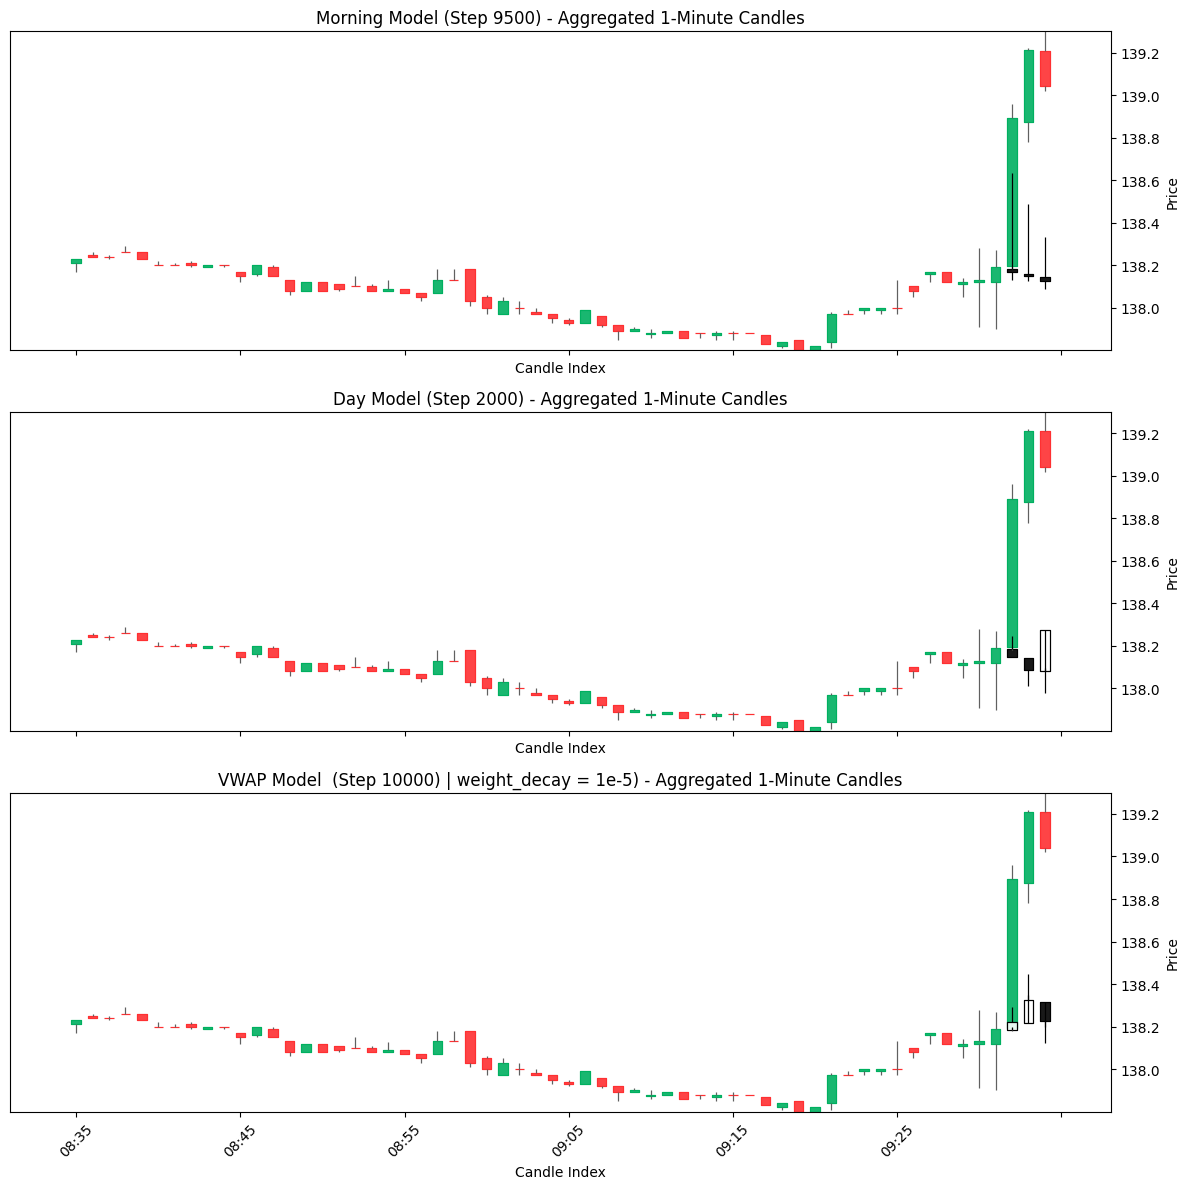

AAPL 2023-11-02: 02:02 PM
Morning Model (Step 9500) - Base Loss Component: SQ 0.3646458387374878 -- ABS 0.40822839736938477
Morning Model (Step 9500) - Body Loss Component: SQ 0.0002627353824209422 -- ABS 0.014723618514835835
Morning Model (Step 9500) - P/L Loss Component: SQ 0.00017799048509914428 -- ABS 0.013341307640075684
Day Model (Step 2000) - Base Loss Component: SQ 0.3719348907470703 -- ABS 0.3773719072341919
Day Model (Step 2000) - Body Loss Component: SQ 0.0003246636188123375 -- ABS 0.01736687682569027
Day Model (Step 2000) - P/L Loss Component: SQ 0.00017799048509914428 -- ABS 0.013341307640075684
VWAP Model  (Step 10000) | weight_decay = 1e-5) - Base Loss Component: SQ 0.3067139983177185 -- ABS 0.37271925806999207
VWAP Model  (Step 10000) | weight_decay = 1e-5) - Body Loss Component: SQ 0.0008148369961418211 -- ABS 0.026033451780676842
VWAP Model  (Step 10000) | weight_decay = 1e-5) - P/L Loss Component: SQ 0.00017799048509914428 -- ABS 0.013341307640075684


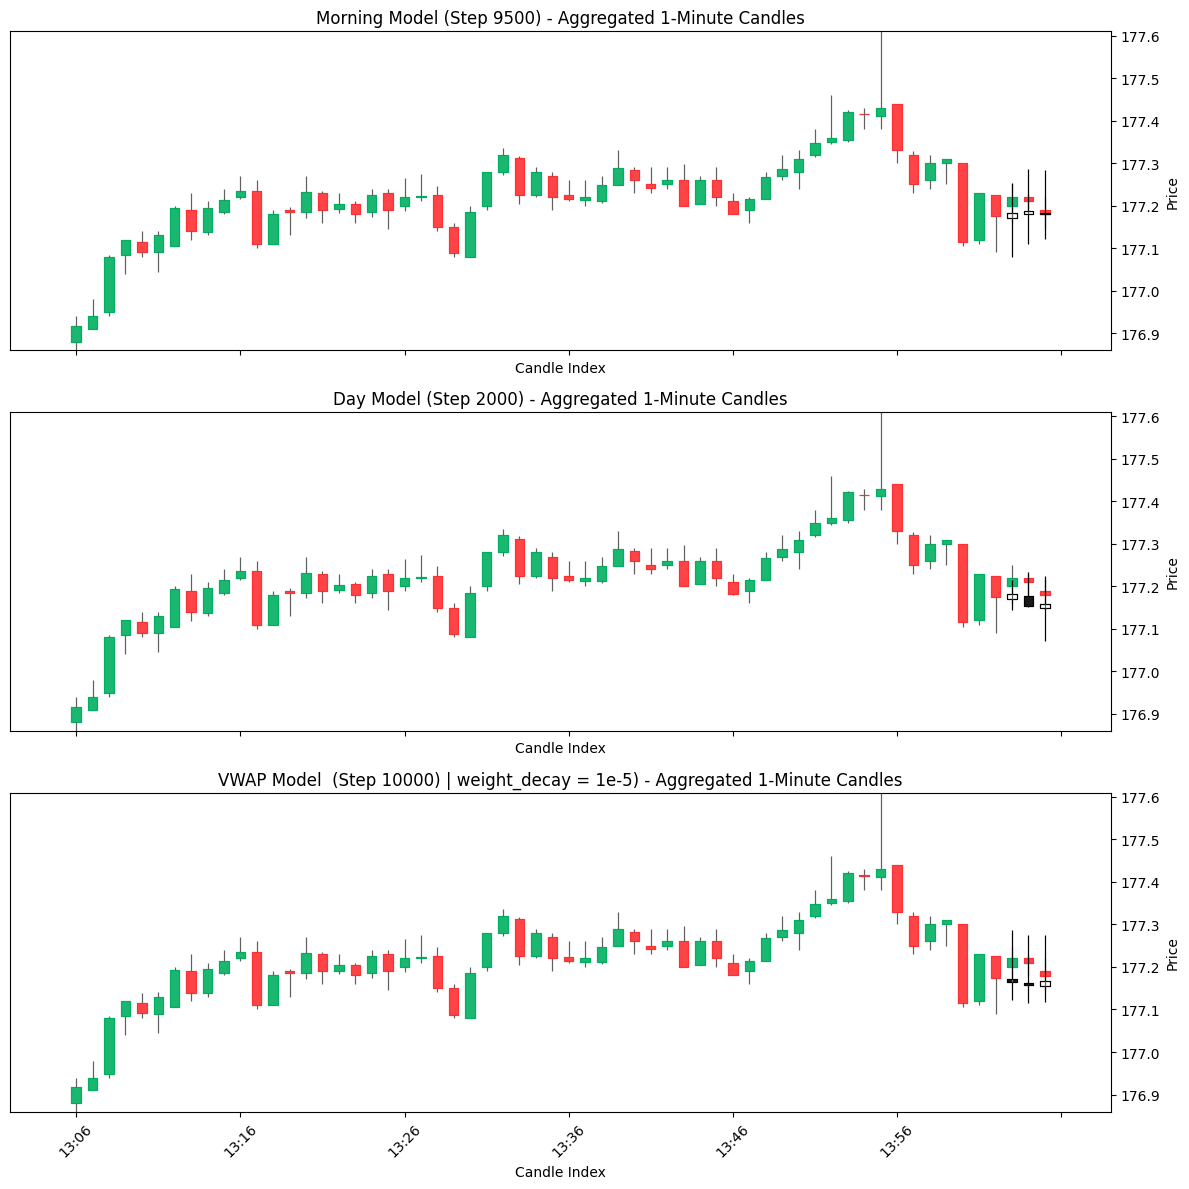

AMZN 2023-08-18: 12:05 PM
Morning Model (Step 9500) - Base Loss Component: SQ 0.3945746123790741 -- ABS 0.41977474093437195
Morning Model (Step 9500) - Body Loss Component: SQ 0.0016333403764292598 -- ABS 0.03131449222564697
Morning Model (Step 9500) - P/L Loss Component: SQ 0.010638522915542126 -- ABS 0.10314321517944336
Day Model (Step 2000) - Base Loss Component: SQ 0.48309680819511414 -- ABS 0.46360981464385986
Day Model (Step 2000) - Body Loss Component: SQ 0.0077845328487455845 -- ABS 0.0880592092871666
Day Model (Step 2000) - P/L Loss Component: SQ 0.05771404504776001 -- ABS 0.24023747444152832
VWAP Model  (Step 10000) | weight_decay = 1e-5) - Base Loss Component: SQ 0.36929526925086975 -- ABS 0.4554719030857086
VWAP Model  (Step 10000) | weight_decay = 1e-5) - Body Loss Component: SQ 0.0028744179289788008 -- ABS 0.039820414036512375
VWAP Model  (Step 10000) | weight_decay = 1e-5) - P/L Loss Component: SQ 0.0005214923876337707 -- ABS 0.02283620834350586


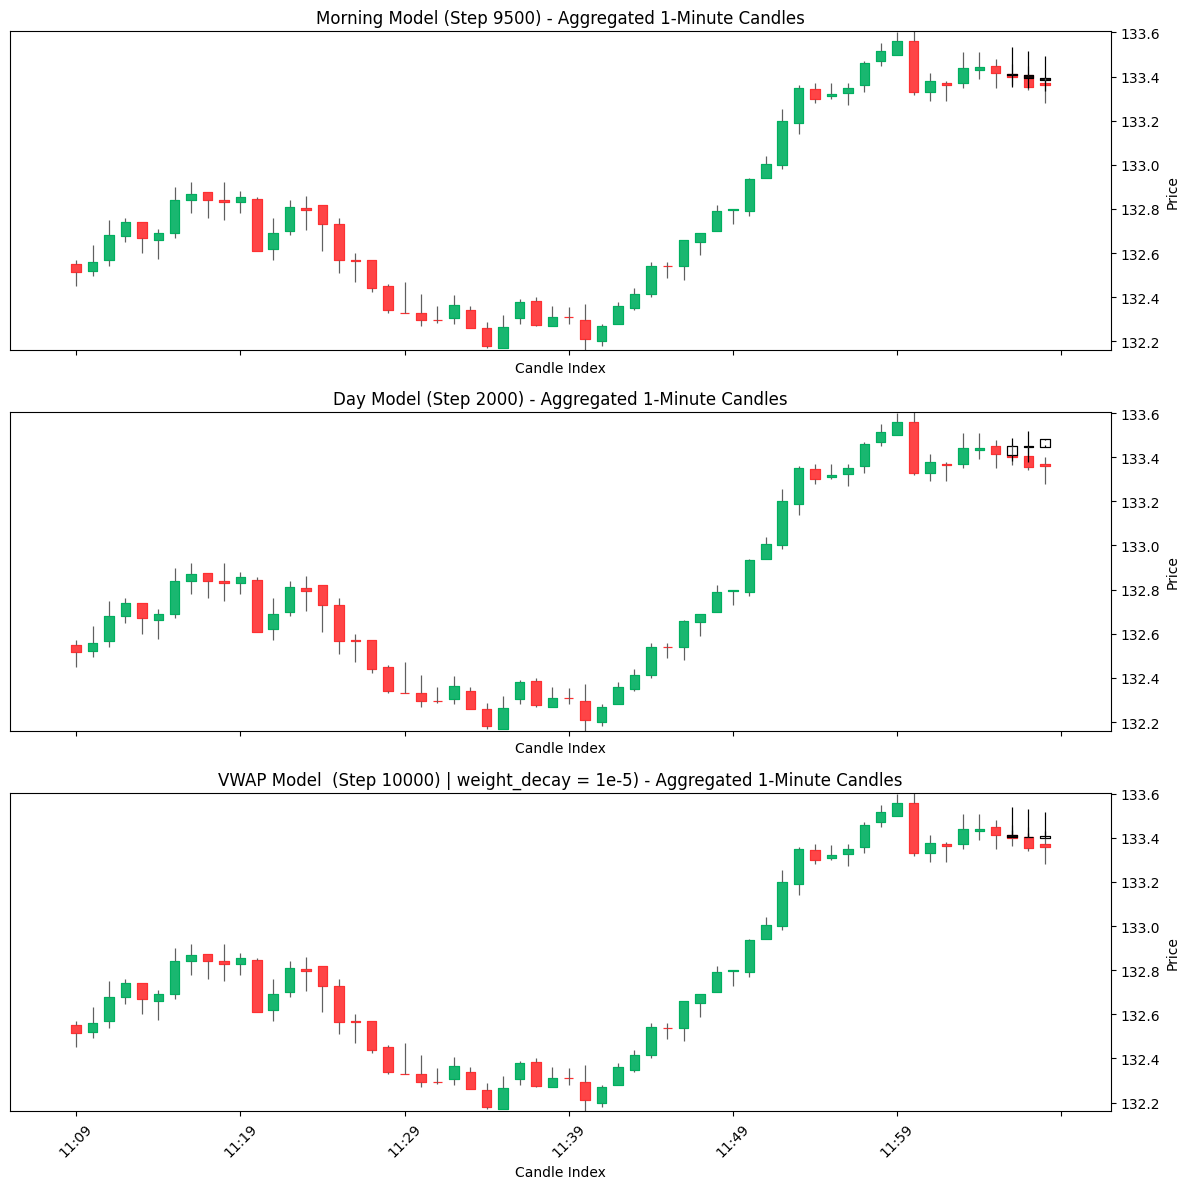

BAC 2023-06-01: 10:08 AM
Morning Model (Step 9500) - Base Loss Component: SQ 0.5048621892929077 -- ABS 0.5094403028488159
Morning Model (Step 9500) - Body Loss Component: SQ 0.005032883025705814 -- ABS 0.06733369827270508
Morning Model (Step 9500) - P/L Loss Component: SQ 8.191781671484932e-05 -- ABS 0.009050846099853516
Day Model (Step 2000) - Base Loss Component: SQ 0.37248799204826355 -- ABS 0.42807164788246155
Day Model (Step 2000) - Body Loss Component: SQ 0.013739586807787418 -- ABS 0.106361985206604
Day Model (Step 2000) - P/L Loss Component: SQ 8.191781671484932e-05 -- ABS 0.009050846099853516
VWAP Model  (Step 10000) | weight_decay = 1e-5) - Base Loss Component: SQ 0.4911390244960785 -- ABS 0.4541870355606079
VWAP Model  (Step 10000) | weight_decay = 1e-5) - Body Loss Component: SQ 0.005533860996365547 -- ABS 0.07228521257638931
VWAP Model  (Step 10000) | weight_decay = 1e-5) - P/L Loss Component: SQ 8.191781671484932e-05 -- ABS 0.009050846099853516


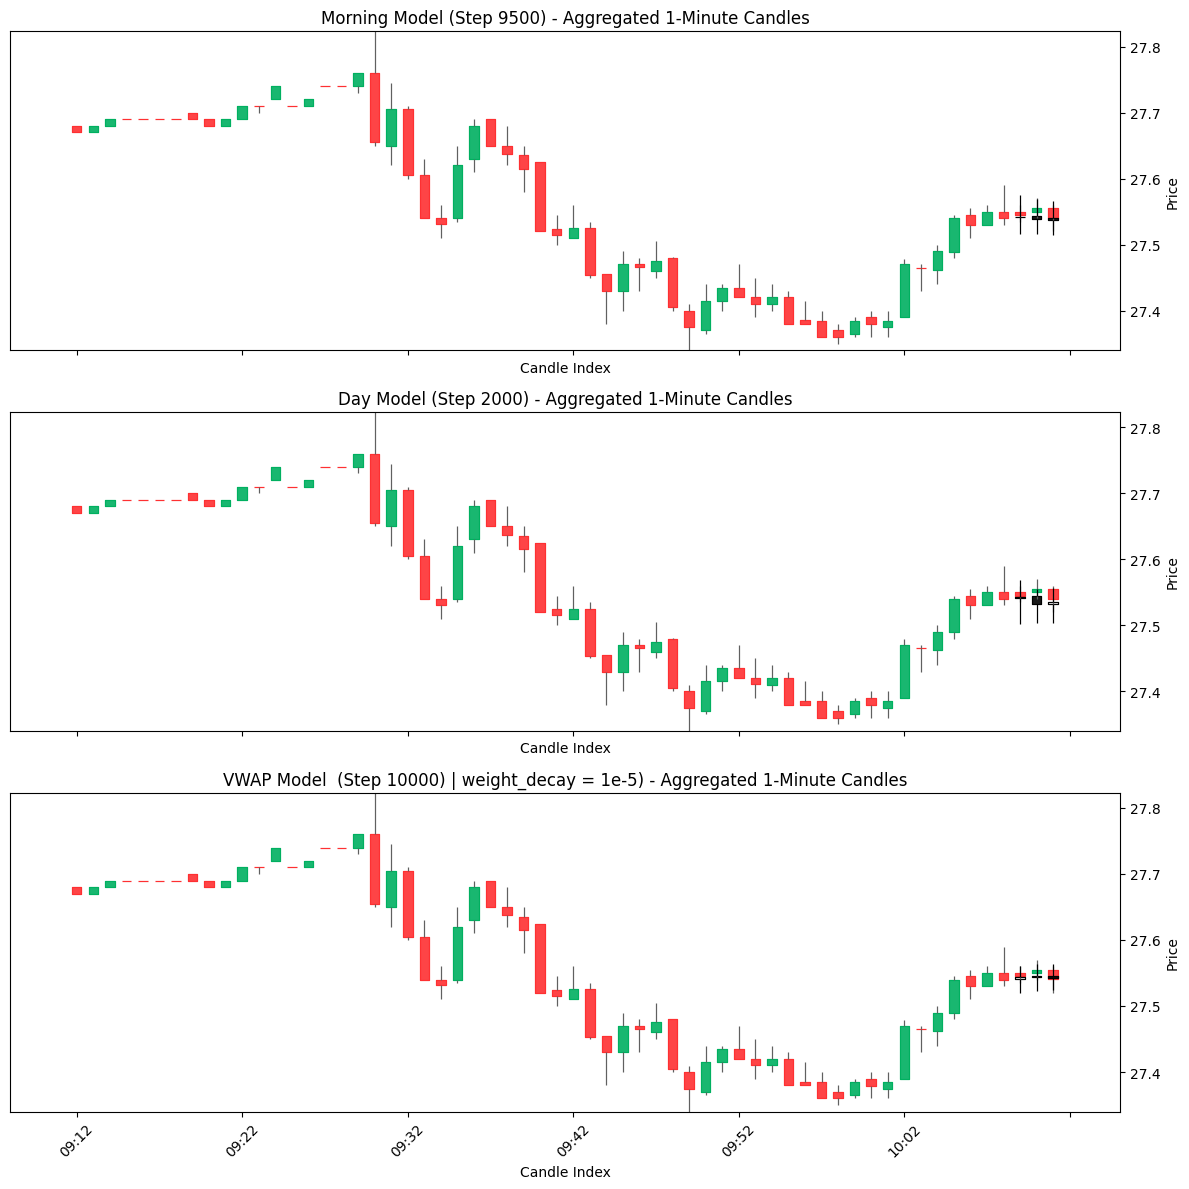

GOOGL 2023-04-13: 02:39 PM
Morning Model (Step 9500) - Base Loss Component: SQ 0.3459542691707611 -- ABS 0.3899107873439789
Morning Model (Step 9500) - Body Loss Component: SQ 0.0027242207434028387 -- ABS 0.051077377051115036
Morning Model (Step 9500) - P/L Loss Component: SQ 0.02264825813472271 -- ABS 0.15049338340759277
Day Model (Step 2000) - Base Loss Component: SQ 0.38701823353767395 -- ABS 0.40767204761505127
Day Model (Step 2000) - Body Loss Component: SQ 0.006200689356774092 -- ABS 0.07778070122003555
Day Model (Step 2000) - P/L Loss Component: SQ 0.02264825813472271 -- ABS 0.15049338340759277
VWAP Model  (Step 10000) | weight_decay = 1e-5) - Base Loss Component: SQ 0.2750758230686188 -- ABS 0.325980544090271
VWAP Model  (Step 10000) | weight_decay = 1e-5) - Body Loss Component: SQ 0.0026147176977247 -- ABS 0.05036666989326477
VWAP Model  (Step 10000) | weight_decay = 1e-5) - P/L Loss Component: SQ 0.02264825813472271 -- ABS 0.15049338340759277


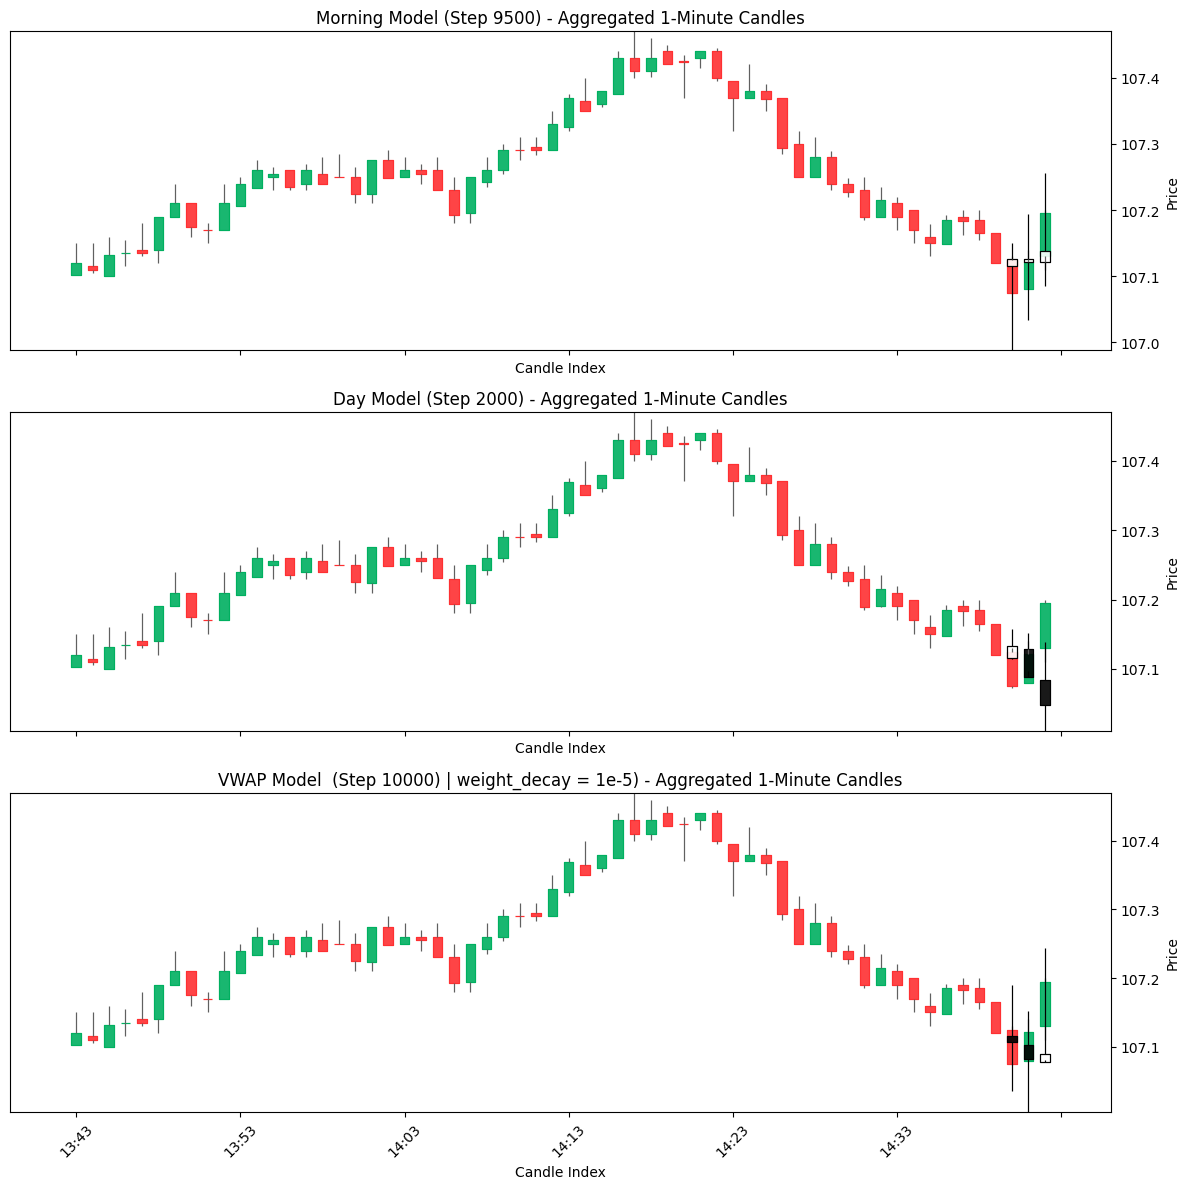

GOOGL 2023-10-27: 12:42 PM
Morning Model (Step 9500) - Base Loss Component: SQ 0.3580186367034912 -- ABS 0.40786507725715637
Morning Model (Step 9500) - Body Loss Component: SQ 0.0021104421466588974 -- ABS 0.042833637446165085
Morning Model (Step 9500) - P/L Loss Component: SQ 0.007884886115789413 -- ABS 0.08879688382148743
Day Model (Step 2000) - Base Loss Component: SQ 0.18329153954982758 -- ABS 0.28560832142829895
Day Model (Step 2000) - Body Loss Component: SQ 0.00025108069530688226 -- ABS 0.012500375509262085
Day Model (Step 2000) - P/L Loss Component: SQ 0.057644832879304886 -- ABS 0.2400933802127838
VWAP Model  (Step 10000) | weight_decay = 1e-5) - Base Loss Component: SQ 0.2845045328140259 -- ABS 0.3709736764431
VWAP Model  (Step 10000) | weight_decay = 1e-5) - Body Loss Component: SQ 0.0026305774226784706 -- ABS 0.048042524605989456
VWAP Model  (Step 10000) | weight_decay = 1e-5) - P/L Loss Component: SQ 0.0010078520281240344 -- ABS 0.03174668550491333


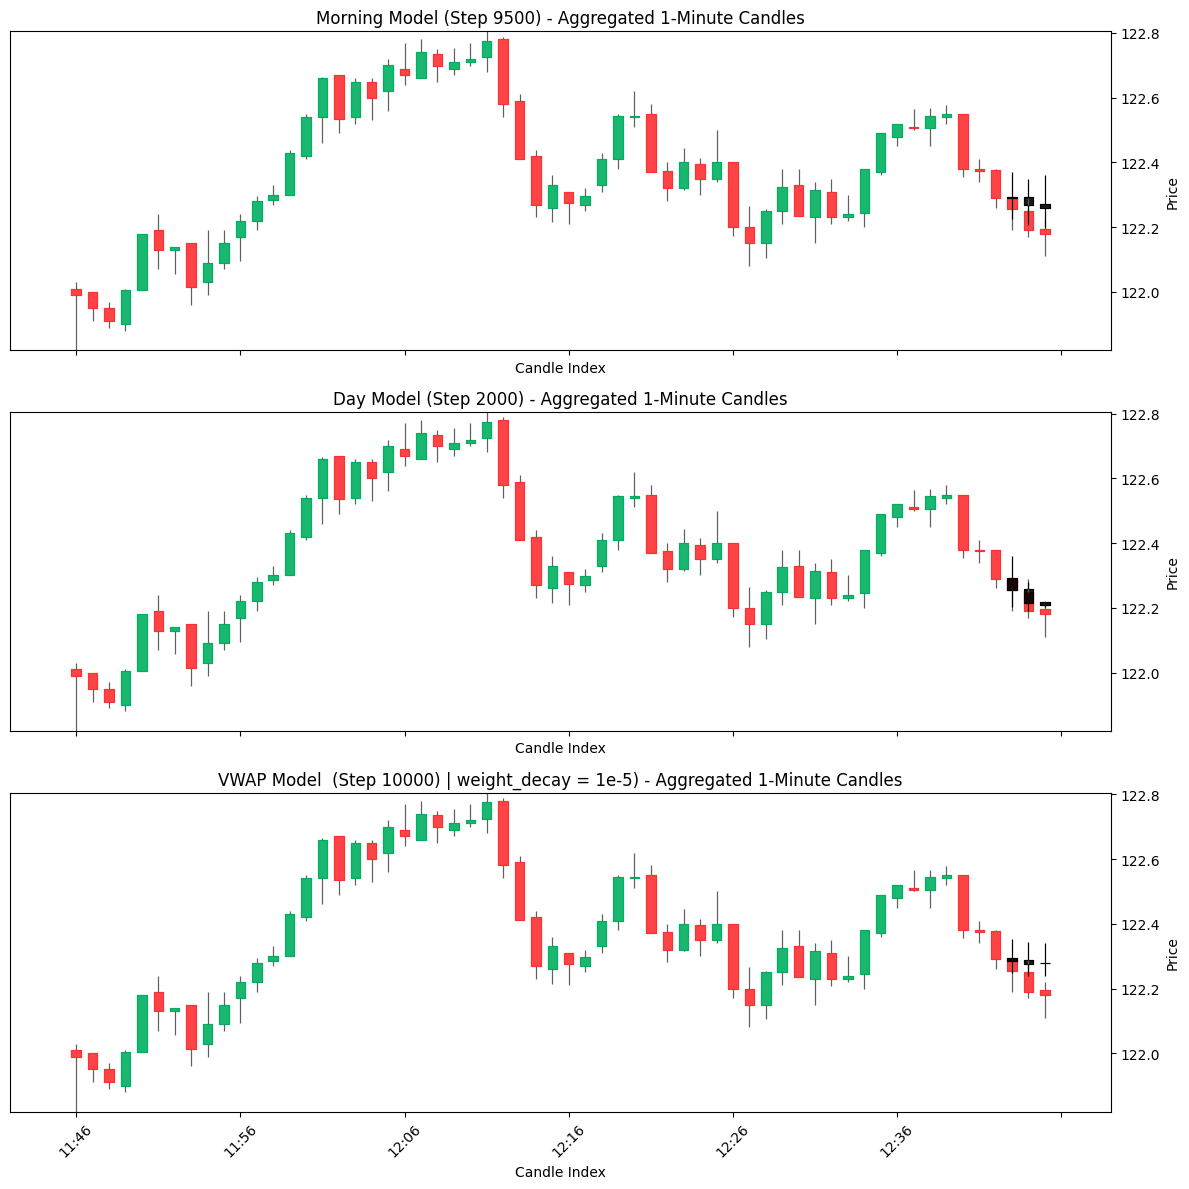

META 2023-08-10: 10:45 AM
Morning Model (Step 9500) - Base Loss Component: SQ 0.3913252651691437 -- ABS 0.4549899101257324
Morning Model (Step 9500) - Body Loss Component: SQ 0.033795956522226334 -- ABS 0.17980830371379852
Morning Model (Step 9500) - P/L Loss Component: SQ 0.10770450532436371 -- ABS 0.328183650970459
Day Model (Step 2000) - Base Loss Component: SQ 0.3102074861526489 -- ABS 0.38018879294395447
Day Model (Step 2000) - Body Loss Component: SQ 0.018834304064512253 -- ABS 0.11972356587648392
Day Model (Step 2000) - P/L Loss Component: SQ 0.10770450532436371 -- ABS 0.328183650970459
VWAP Model  (Step 10000) | weight_decay = 1e-5) - Base Loss Component: SQ 0.3954474627971649 -- ABS 0.4422941207885742
VWAP Model  (Step 10000) | weight_decay = 1e-5) - Body Loss Component: SQ 0.03223353624343872 -- ABS 0.1766829937696457
VWAP Model  (Step 10000) | weight_decay = 1e-5) - P/L Loss Component: SQ 0.10770450532436371 -- ABS 0.328183650970459


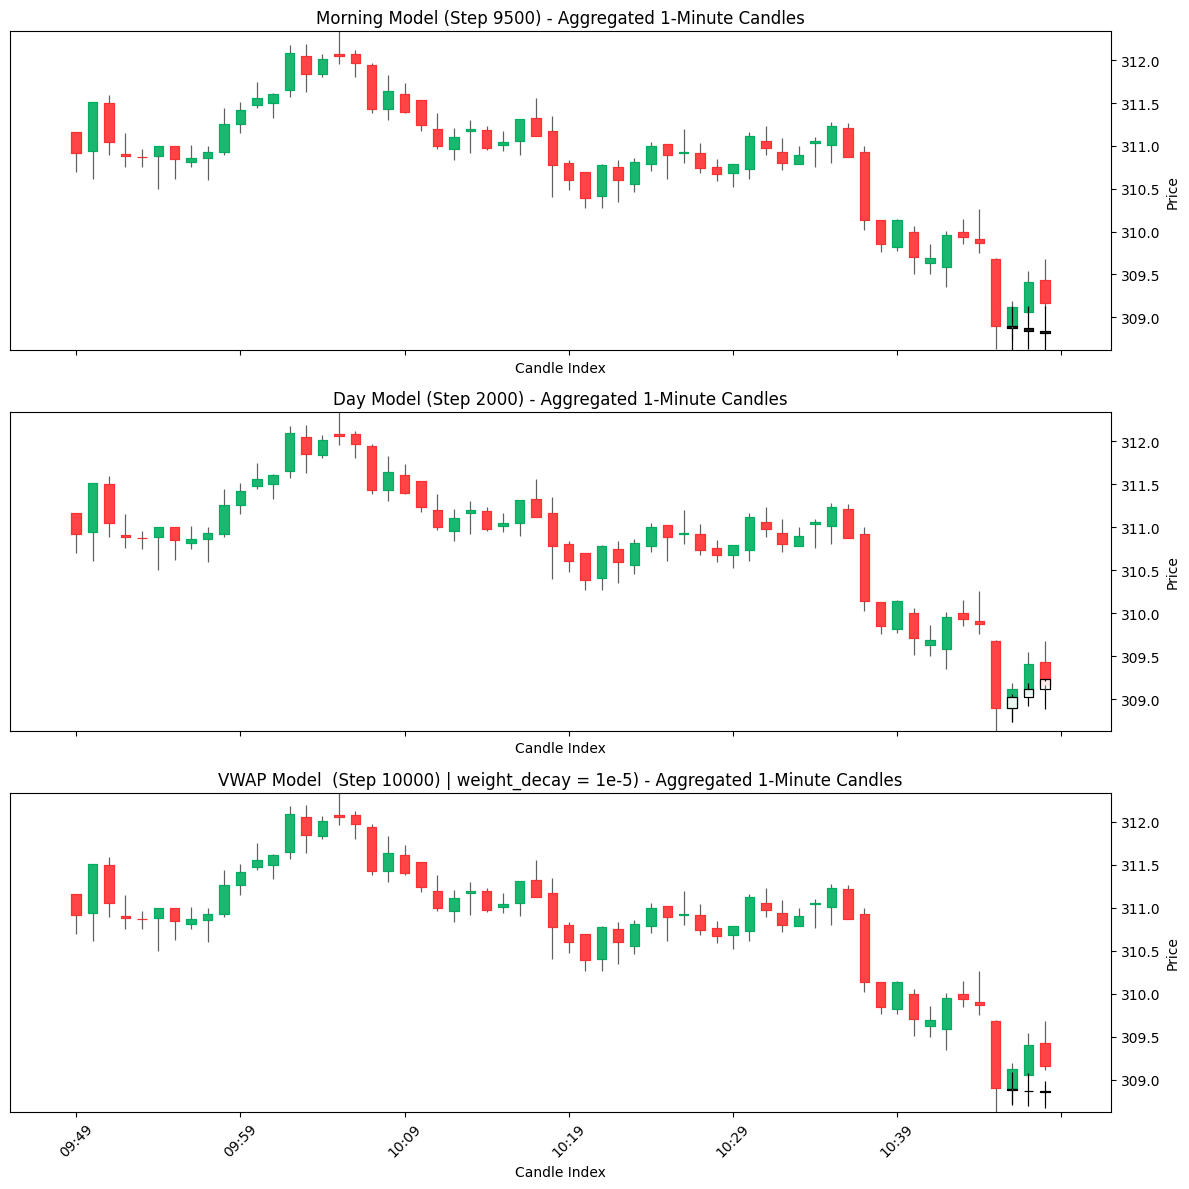

MSFT 2023-05-01: 03:16 PM
Morning Model (Step 9500) - Base Loss Component: SQ 0.31582769751548767 -- ABS 0.3708813488483429
Morning Model (Step 9500) - Body Loss Component: SQ 0.033146243542432785 -- ABS 0.1646144986152649
Morning Model (Step 9500) - P/L Loss Component: SQ 0.009916471317410469 -- ABS 0.09958148002624512
Day Model (Step 2000) - Base Loss Component: SQ 0.3059096038341522 -- ABS 0.39041149616241455
Day Model (Step 2000) - Body Loss Component: SQ 0.02402537502348423 -- ABS 0.1313369870185852
Day Model (Step 2000) - P/L Loss Component: SQ 0.009916471317410469 -- ABS 0.09958148002624512
VWAP Model  (Step 10000) | weight_decay = 1e-5) - Base Loss Component: SQ 0.34057390689849854 -- ABS 0.375552773475647
VWAP Model  (Step 10000) | weight_decay = 1e-5) - Body Loss Component: SQ 0.030383393168449402 -- ABS 0.16270126402378082
VWAP Model  (Step 10000) | weight_decay = 1e-5) - P/L Loss Component: SQ 0.009916471317410469 -- ABS 0.09958148002624512


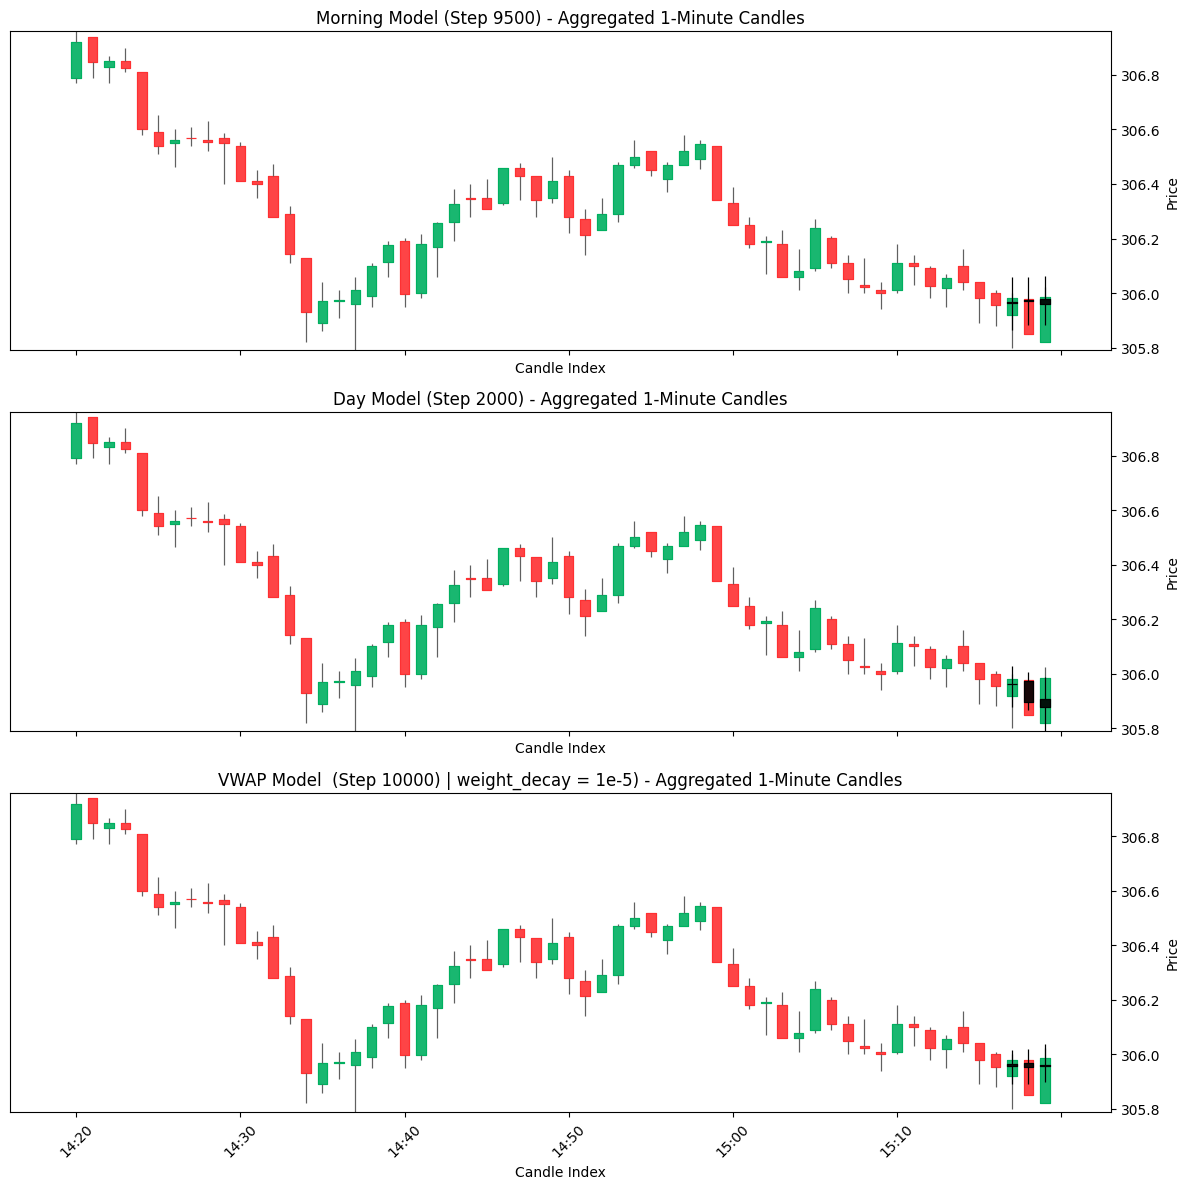

NVDA 2023-04-20: 01:19 PM
Morning Model (Step 9500) - Base Loss Component: SQ 0.2996332347393036 -- ABS 0.3622891902923584
Morning Model (Step 9500) - Body Loss Component: SQ 0.004315608646720648 -- ABS 0.05465182662010193
Morning Model (Step 9500) - P/L Loss Component: SQ 0.0008058325038291514 -- ABS 0.02838718891143799
Day Model (Step 2000) - Base Loss Component: SQ 0.3603770434856415 -- ABS 0.40660354495048523
Day Model (Step 2000) - Body Loss Component: SQ 0.006160501390695572 -- ABS 0.06417948007583618
Day Model (Step 2000) - P/L Loss Component: SQ 9.124301868723705e-05 -- ABS 0.00955212116241455
VWAP Model  (Step 10000) | weight_decay = 1e-5) - Base Loss Component: SQ 0.3020426630973816 -- ABS 0.37290287017822266
VWAP Model  (Step 10000) | weight_decay = 1e-5) - Body Loss Component: SQ 0.004588831681758165 -- ABS 0.05380938574671745
VWAP Model  (Step 10000) | weight_decay = 1e-5) - P/L Loss Component: SQ 0.0004587092553265393 -- ABS 0.02141749858856201


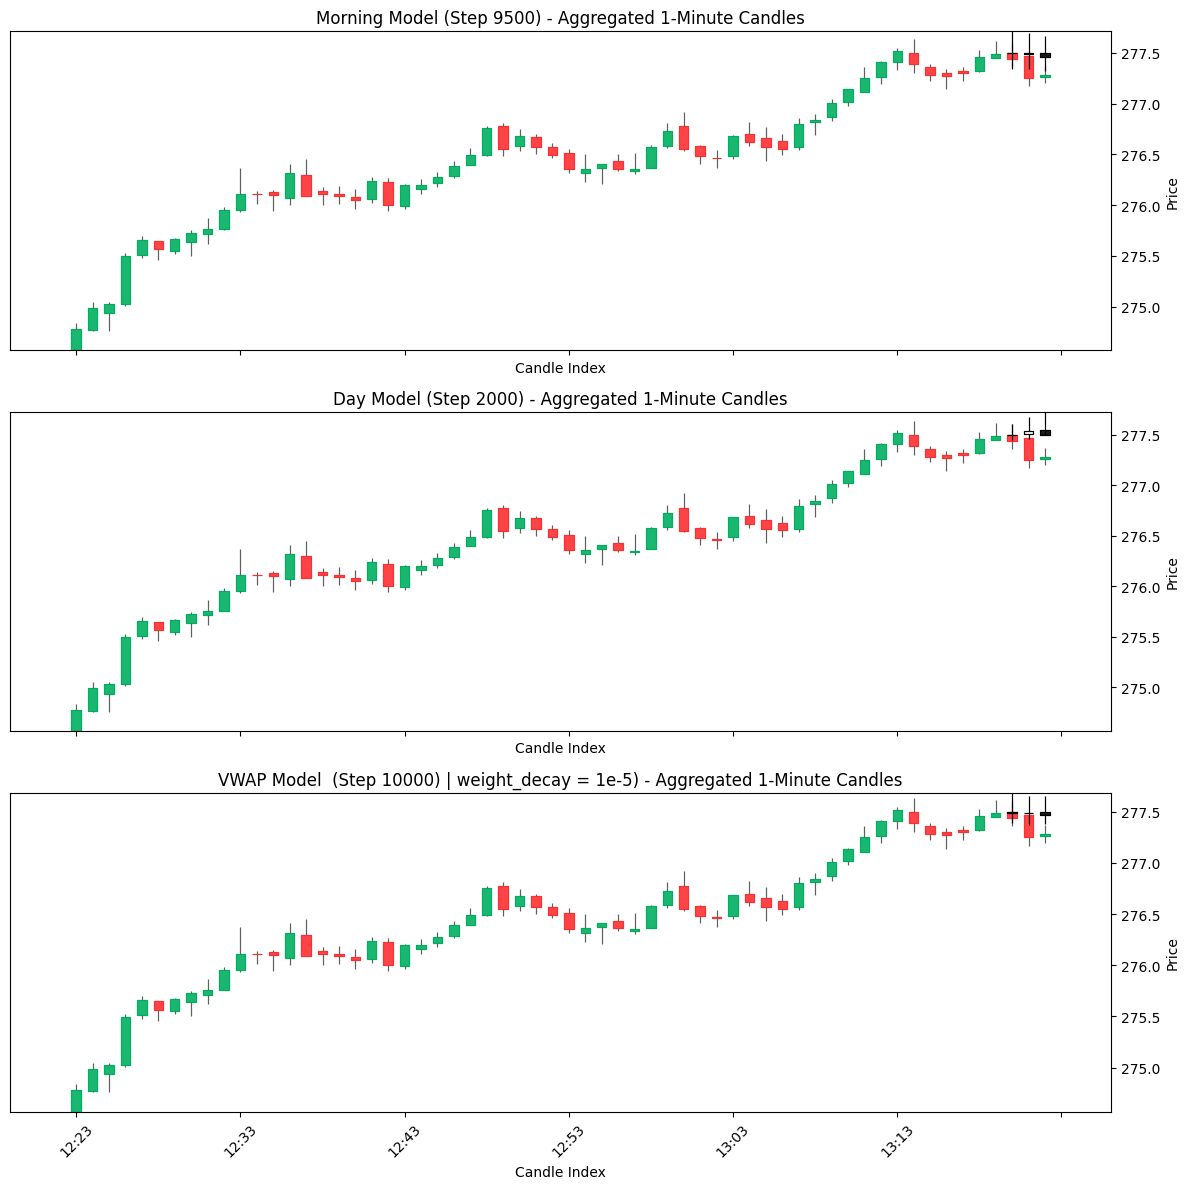

NVDA 2023-11-16: 11:22 AM
Morning Model (Step 9500) - Base Loss Component: SQ 0.37975430488586426 -- ABS 0.42772674560546875
Morning Model (Step 9500) - Body Loss Component: SQ 0.006407564505934715 -- ABS 0.0679553896188736
Morning Model (Step 9500) - P/L Loss Component: SQ 0.009220601059496403 -- ABS 0.09602396190166473
Day Model (Step 2000) - Base Loss Component: SQ 0.3287133276462555 -- ABS 0.3661220967769623
Day Model (Step 2000) - Body Loss Component: SQ 0.011359021998941898 -- ABS 0.07887224107980728
Day Model (Step 2000) - P/L Loss Component: SQ 0.11273905634880066 -- ABS 0.33576637506484985
VWAP Model  (Step 10000) | weight_decay = 1e-5) - Base Loss Component: SQ 0.3171274662017822 -- ABS 0.3728531301021576
VWAP Model  (Step 10000) | weight_decay = 1e-5) - Body Loss Component: SQ 0.007031407207250595 -- ABS 0.06802163273096085
VWAP Model  (Step 10000) | weight_decay = 1e-5) - P/L Loss Component: SQ 0.00099652586504817 -- ABS 0.03156779706478119


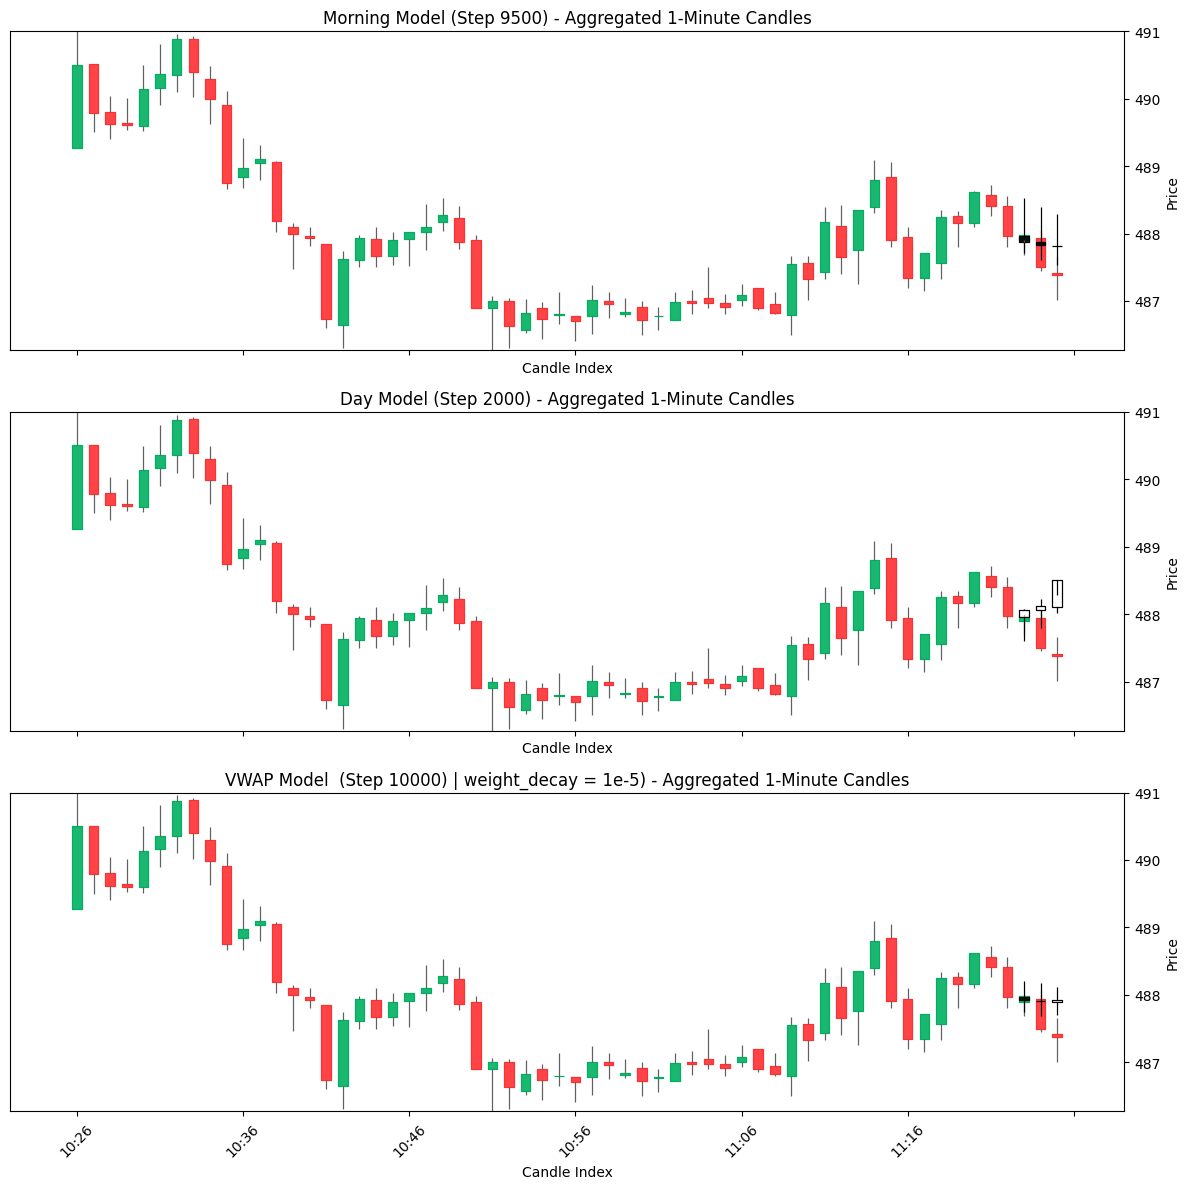

V 2023-03-13: 03:53 PM
Morning Model (Step 9500) - Base Loss Component: SQ 0.983971357345581 -- ABS 0.622408390045166
Morning Model (Step 9500) - Body Loss Component: SQ 0.04510403797030449 -- ABS 0.1453261375427246
Morning Model (Step 9500) - P/L Loss Component: SQ 0.0006845453171990812 -- ABS 0.026163816452026367
Day Model (Step 2000) - Base Loss Component: SQ 1.4569951295852661 -- ABS 0.6879206299781799
Day Model (Step 2000) - Body Loss Component: SQ 0.03343215957283974 -- ABS 0.13032083213329315
Day Model (Step 2000) - P/L Loss Component: SQ 0.005971855018287897 -- ABS 0.0772777795791626
VWAP Model  (Step 10000) | weight_decay = 1e-5) - Base Loss Component: SQ 1.390492558479309 -- ABS 0.675574779510498
VWAP Model  (Step 10000) | weight_decay = 1e-5) - Body Loss Component: SQ 0.04425710067152977 -- ABS 0.14660409092903137
VWAP Model  (Step 10000) | weight_decay = 1e-5) - P/L Loss Component: SQ 0.000775750435423106 -- ABS 0.027852296829223633


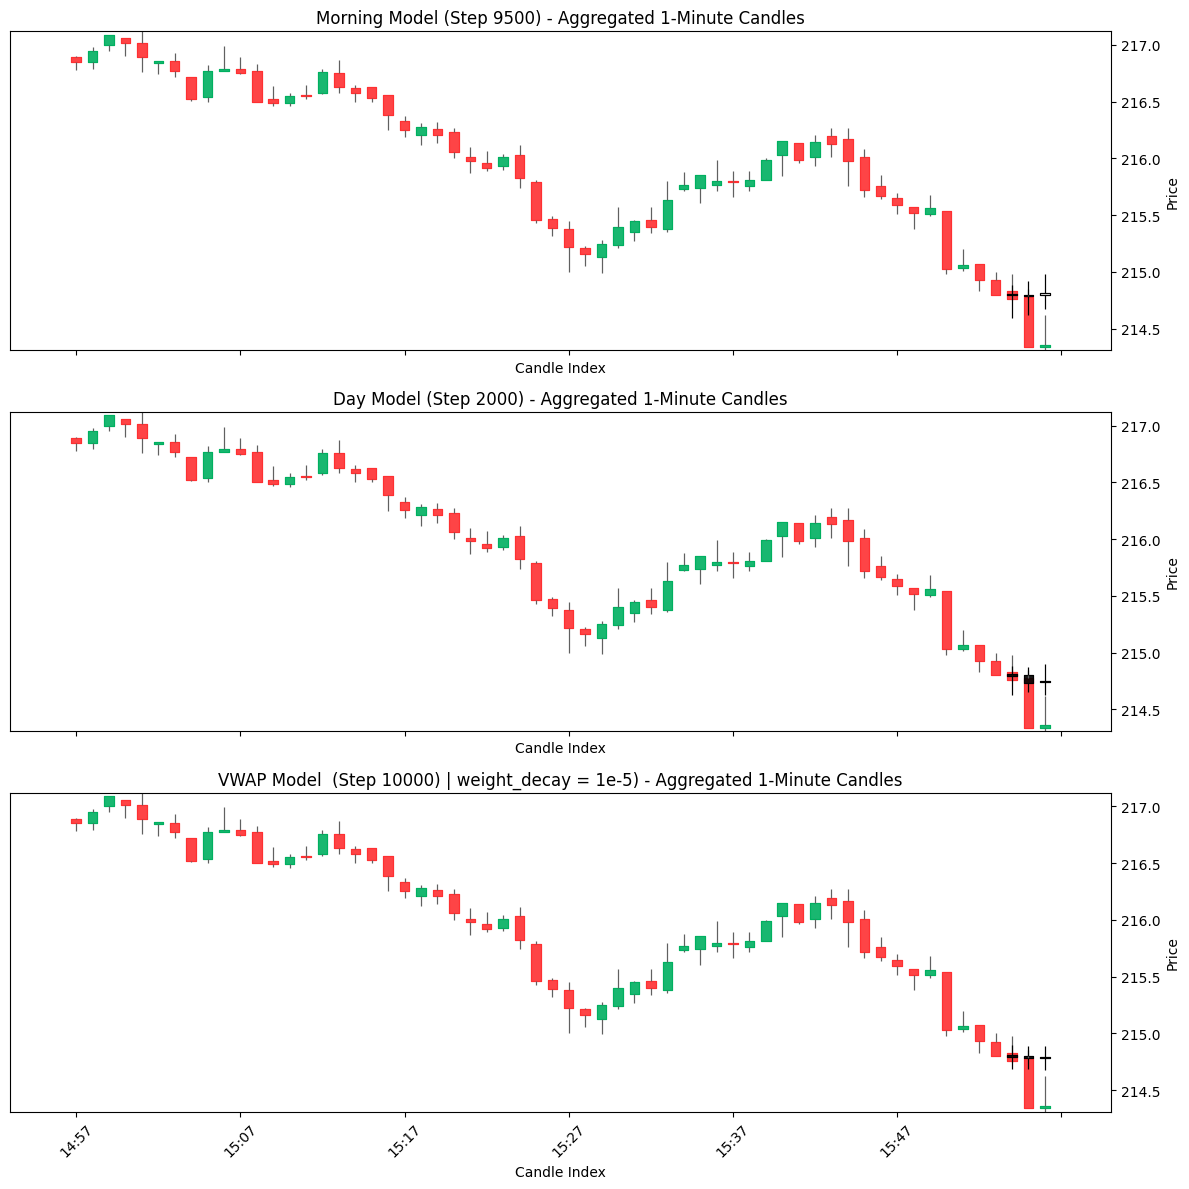

In [553]:
# Get 10 examples for testing the plotting the model's performance
for i in range(2, len(scaled_test_dataset), (len(scaled_test_dataset) - 1) // 10):
    infer_and_plot(i, model_dict)
    